**Implement AdaBoost with decision stumps, i.e., 1-level decision trees**

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
from sklearn.datasets import make_blobs
import pandas as pd

In [2]:
# Decision stump h as each weak classifier
# [axis,threshold,polarity,beta] where beta is the weight/contribution of the current weak classifier
class DecisionStump():
    def __init__(self):
        self.polarity = 1
        self.axis = None
        self.threshold = None
        # weak classifier's contribution
        self.beta = None

In [17]:

class AdaBoost:
    def __init__(self, X, y, T):
        # Initialize the model
        # X: data points
        # y: labels
        # T: number of iterations
        # w: weights
        # N: number of training data points

        self.X = X
        self.y = y
        self.T = T
        self.N = X.shape[0]

        # initialize weight --> update later for each each iteration
        self.w = np.ones(self.N) / self.N

        # record the weak classifiers
        self.clfs = []
        self.error_list = []

    def find_next_weak_Learner(self):
        # Find best decision stump
        # Output should define the axis, threshold, polarity and weight of the decision stump
        # You should also update the weights of the data points here

        # TODO
        clf = DecisionStump()

        # minimize error over each feature in X for each distincy value --> find proper threshold
        min_error = math.inf

        feature_size = self.X.shape[1]

        for i in range(feature_size):
            feature_vals = np.expand_dims(self.X[:, i], axis=1)
            unique_column_vals = np.unique(feature_vals)
            for thresh in unique_column_vals:
                polarity = 1
                prediction = np.ones(np.shape(self.y))
                # mark labels of data points who are below threshold as -1
                prediction[self.X[:, i] < thresh] = -1
                # Error = sum of weights of misclassified samples
                error = sum(self.w[self.y != prediction])
                # flip error and polarity in case error is larger than 0.5 --> adjust polarity
                if error > 0.5:
                    error = 1 - error
                    polarity = -1
                if error < min_error:
                    clf.polarity = polarity
                    clf.threshold = thresh
                    clf.axis = i
                    min_error = error
        # compute beta
        clf.beta = (1/2) * math.log((1.0 - min_error) / (min_error + 1e-8)) # in case zero factor
        # compute h_t(x), the prediction using current weak classifier
        hs = np.ones(np.shape(self.y))
        neg_idx = (clf.polarity * self.X[:, clf.axis] < clf.polarity * clf.threshold)
        hs[neg_idx] = -1
        # update sample weights
        self.w *= np.exp(-clf.beta * self.y * hs)
        # normalize sample weight w
        self.w /= np.sum(self.w)

        # record the current weak classifier to the classifier list
        self.clfs.append(clf)
        self.error_list.append(min_error)



    def train(self):
        self.clfs = []
        for t in range(self.T):

            self.find_next_weak_Learner()


    def predict_K(self, X, K):

        n_samples = np.shape(X)[0]
        y_pred = np.zeros((n_samples, 1))
        # For each classifier => label the samples
        for clf in self.clfs[:K]:
            # compute prediction
            hs = np.ones(np.shape(y_pred))
            neg_idx = (clf.polarity * X[:, clf.axis] < clf.polarity * clf.threshold)
            hs[neg_idx] = -1
            # add weighted prediction
            y_pred += clf.beta * hs

        # return sign of prediction sum
        y_pred = np.sign(y_pred)

        return y_pred


    def accuracy_K(self, X, y, K):
        # Compute accuracy of the model for (X, y) using first K weak learners
        # Output should be a scalar in [0, 1]
        # TODO
        true_count = 0
        y_pred = self.predict_K(X, K)
        for i in range(len(X)):
            if y_pred[i] == y[i]:
                true_count += 1
        return true_count/len(X)

    def scatter_plot(self):
        # Plot the data points and the decision boundary
        # You need not edit this function as long as you have defined the predict_K function properly
        X = np.asarray([[x_cor, y_cor] for x_cor in np.linspace(np.amin(self.X[:, 0]), np.amax(self.X[:, 0]), 500) for y_cor in np.linspace(np.amin(self.X[:, 1]), np.amax(self.X[:, 1]), 500)])

        fig, ax = plt.subplots(3, 3, figsize=(30, 30))

        for i, K in enumerate([1, 5, 10, 20, 30, 100, 200, 400, 600]):
            # Plot the data points and the decision boundary using k weak learners
            print("Plotting the data points and the decision boundary using {} weak learners".format(K))
            Z_pred = self.predict_K(X, K)

            ax[i // 3, i % 3].scatter(X[:, 0], X[:, 1], c=['white' if z == 1 else 'orange' for z in Z_pred], s=1)
            for numpoint, point in enumerate(self.X):
                ax[i // 3, i % 3].scatter(point[0], point[1], c='black' if self.y[numpoint]==1 else 'red', marker='x' if self.y[numpoint]==1 else 'o')
            ax[i // 3, i % 3].set_title("K = {}".format(K), fontsize=20)
        plt.show()


    def error_plots(self):
        # plot e_ts
        plt.plot(range(1, T + 1), self.error_list)
        plt.xlabel('The iteration')
        plt.ylabel('Weak learner error')
        plt.show()



**Code for Training Routine**

Load Data


In [18]:
df_train = pd.read_csv('/content/Syndata-train.csv')
df_test = pd.read_csv('/content/Syndata-test.csv')

In [19]:
df_train.head()

,feature1,feature2,label
0,-0.241317,-0.985089,-1.0
1,-0.086146,-1.048986,-1.0
2,-0.566993,-0.191554,1.0
3,0.256527,0.015828,1.0
4,-0.945932,-0.557826,-1.0


In [20]:
df_test.head()

,feature1,feature2,label
0,0.373330,-0.350583,1.0
1,-0.150538,-0.758157,-1.0
2,-0.224754,-0.178683,1.0
3,-0.345755,0.380122,1.0
4,-0.207811,-0.278812,1.0


In [21]:
X = df_train.iloc[:,:-1].values
y = df_train.iloc[:,-1].values
X_test = df_test.iloc[:,:-1].values
y_test = df_test.iloc[:,-1].values

In [22]:
X[30:50], len(X), type(X)

(array([[ 0.74254484,  0.06463216],
        [ 0.01760382,  1.05998244],
        [-0.00187649,  0.98016946],
        [ 0.79603553,  0.07983904],
        [-0.51487129,  0.36395037],
        [ 0.54597971,  0.51938795],
        [-0.441615  ,  0.8821161 ],
        [ 0.3281638 ,  0.52171776],
        [-0.57683515, -0.7532229 ],
        [-0.47073413,  0.58435328],
        [-0.62907691,  0.71682168],
        [-0.32930511, -0.54754133],
        [-0.67421543, -1.09216261],
        [ 0.02763192,  0.41901209],
        [-0.48321322, -0.86265716],
        [-0.28087681,  0.50411083],
        [ 0.76825304,  0.06329926],
        [ 0.04015808, -0.46037344],
        [ 0.03273587,  0.18402088],
        [ 0.07520467, -0.55920884]]),
 800,
 numpy.ndarray)

In [23]:
y[30:50], len(y), type(y)

(array([ 1., -1., -1., -1.,  1., -1., -1.,  1., -1., -1., -1.,  1., -1.,
         1., -1.,  1., -1.,  1.,  1.,  1.]),
 800,
 numpy.ndarray)

Text(0.5, 1.0, 'Training data')

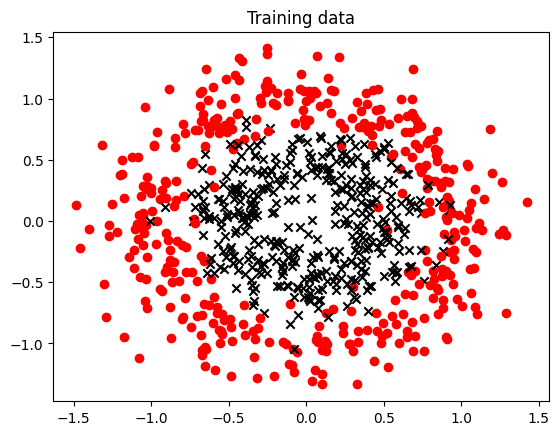

In [24]:
#---------------Plot the training data
fig, ax = plt.subplots()
for numpoint, point in enumerate(X):
    ax.scatter(point[0], point[1], c='black' if y[numpoint]==1 else 'red', marker='x' if y[numpoint]==1 else 'o')
ax.set_title('Training data')

Text(0.5, 1.0, 'Training data')

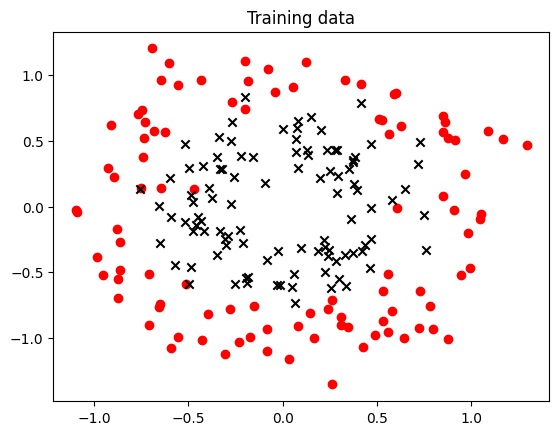

In [25]:
#---------------Plot the testing data
fig, ax = plt.subplots()
for numpoint, point in enumerate(X_test):
    ax.scatter(point[0], point[1], c='black' if y_test[numpoint]==1 else 'red', marker='x' if y_test[numpoint]==1 else 'o')
ax.set_title('Training data')

In [26]:
#Start Training
T=20
train_adaboost = AdaBoost(X, y, T)
train_adaboost.train()

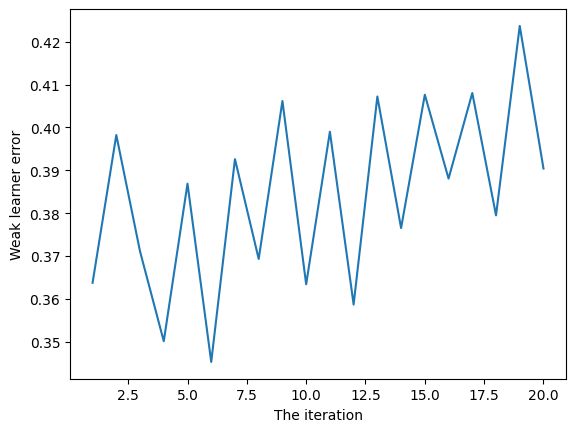

In [27]:
train_adaboost.error_plots()

ارور های مختلف مربوط به دسته بند های ضعیف مختلف و هر کدوم میتونند متفاوت باشند دیگه با توجه به الگوریتم ادابوست همین گونه است و در اینجا بیشترین ارور مربوط به دسته بند ضعیف 19 است

# **قسمت دوم**

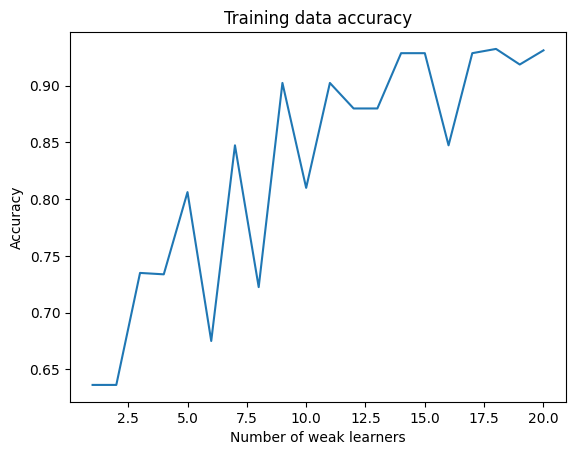

In [32]:
# Plot training data accuracy
accuracy_score = []
for t in range(T):
    accuracy_score.append(train_adaboost.accuracy_K(X, y, t + 1))
plt.plot(range(1, T + 1), accuracy_score)
plt.xlabel('Number of weak learners')
plt.ylabel('Accuracy')
plt.title('Training data accuracy')
plt.show()

در این قسمت هم برای خطای دسته بند نهایی در هر دور میتوانیم دقت مدل را بر حسب تعداد دسته بند های ضعیف رسم کنیم .که با زیاد شدن تعداد دسته بند ها دقت هم افزایش پیدا میکند.

# **قسمت سوم**

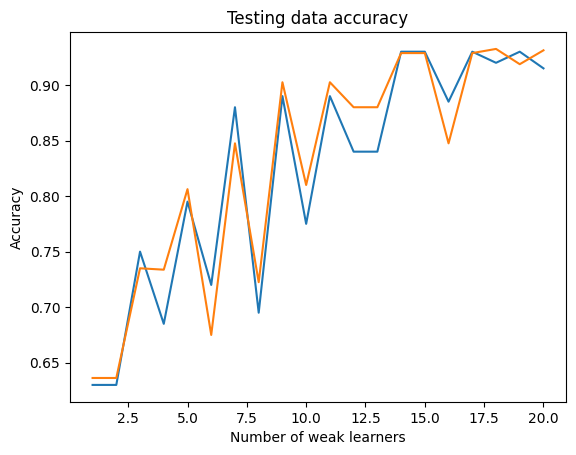

In [33]:
# Plot testing data accuracy
accuracy_score_test = []
for t in range(T):
    accuracy_score_test.append(train_adaboost.accuracy_K(X_test, y_test, t + 1))
plt.plot(range(1, T + 1), accuracy_score_test)
plt.plot(range(1, T + 1), accuracy_score)
plt.xlabel('Number of weak learners')
plt.ylabel('Accuracy')
plt.title('Testing data accuracy')
plt.show()

نمیدونم منظور از تفسیر اینجا دقیقا چی میتونه باشه ولی خب نمودار ها به طرز خوبی منطبق هستند و این یعنی یادگیری خوب انجام شده و بیش برازش یا کم برازش نداریم

# **قسمت چهارم**

In [34]:
def test_train_plot(T):
  accuracy_score = []
  for t in range(T):
    accuracy_score.append(train_adaboost.accuracy_K(X, y, t + 1))
  accuracy_score_test = []
  for t in range(T):
      accuracy_score_test.append(train_adaboost.accuracy_K(X_test, y_test, t + 1))
  plt.plot(range(1, T + 1), accuracy_score_test)
  plt.plot(range(1, T + 1), accuracy_score)
  plt.xlabel('Number of weak learners')
  plt.ylabel('Accuracy')
  plt.title('Testing data accuracy')
  plt.show()

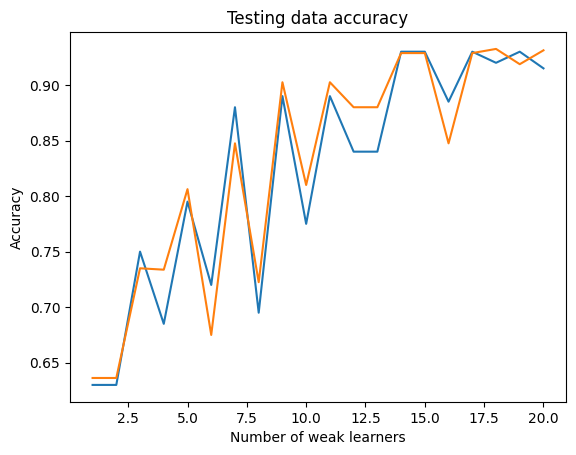

In [35]:
test_train_plot(20)

In [37]:
all_iteration = [20, 50, 100, 200, 500, 1000, 2000, 4000]

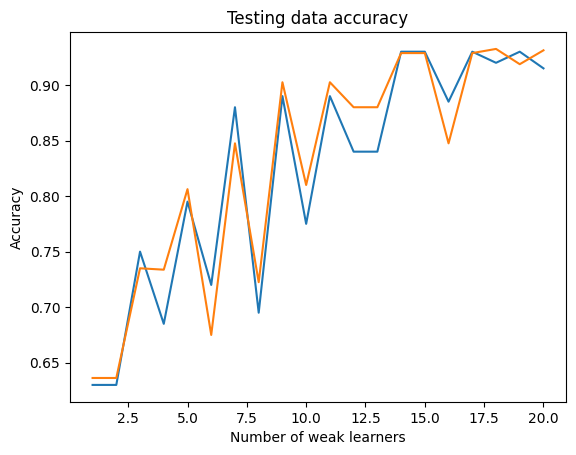

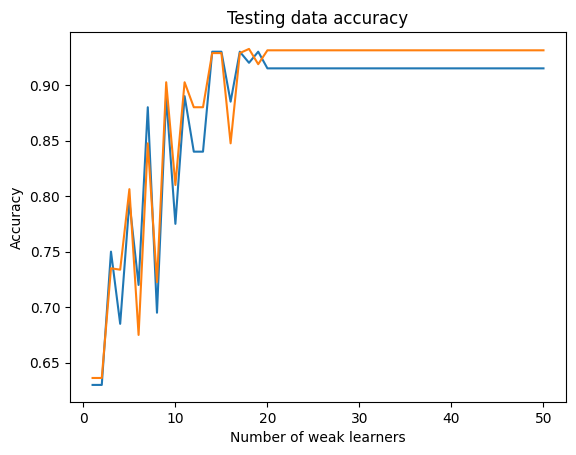

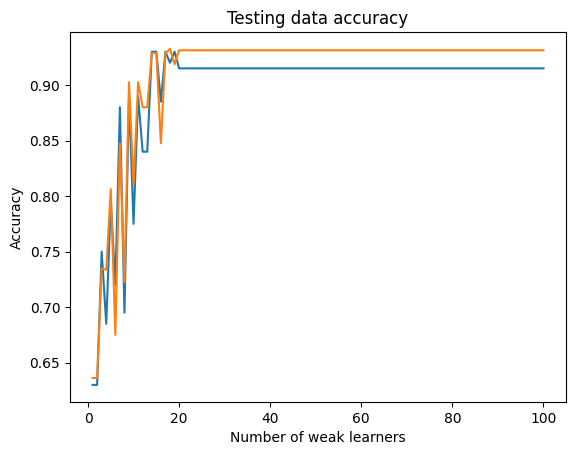

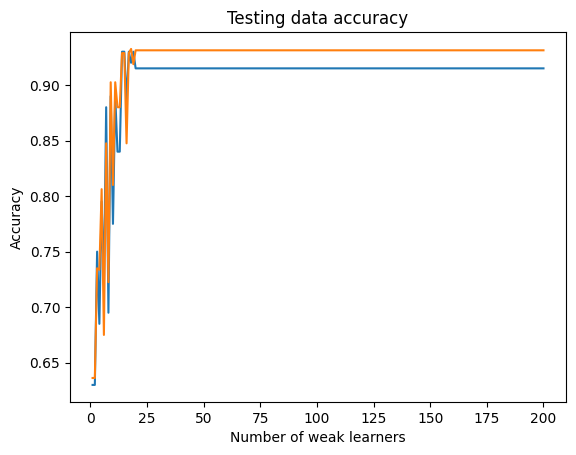

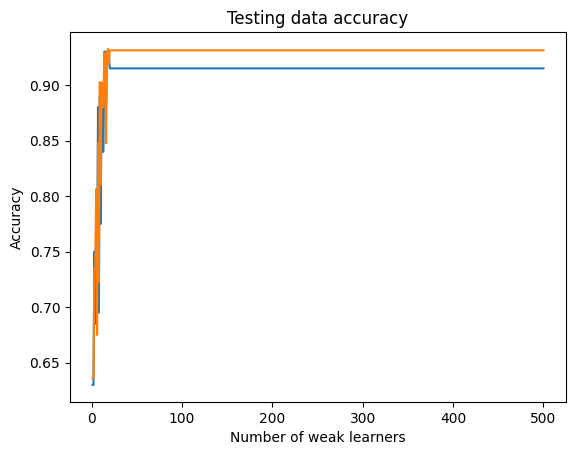

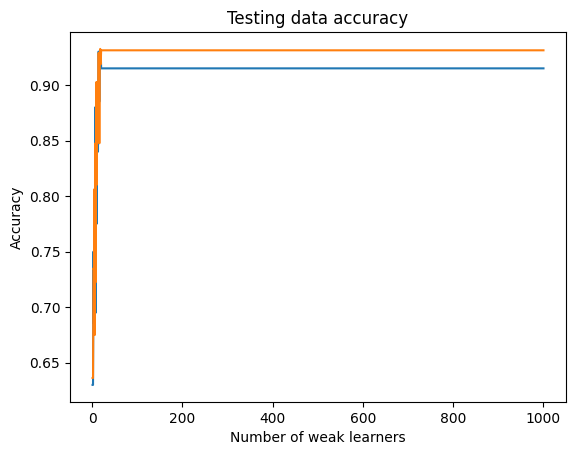

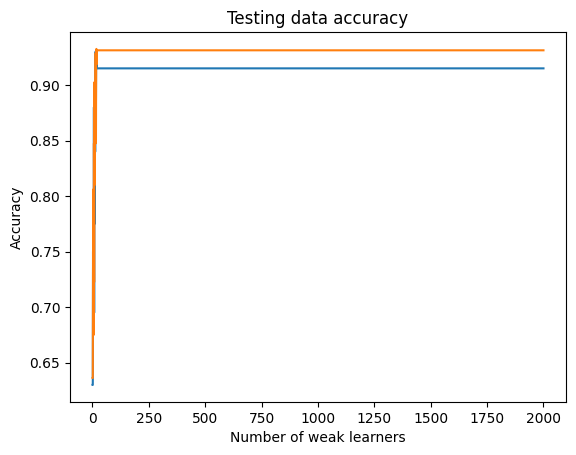

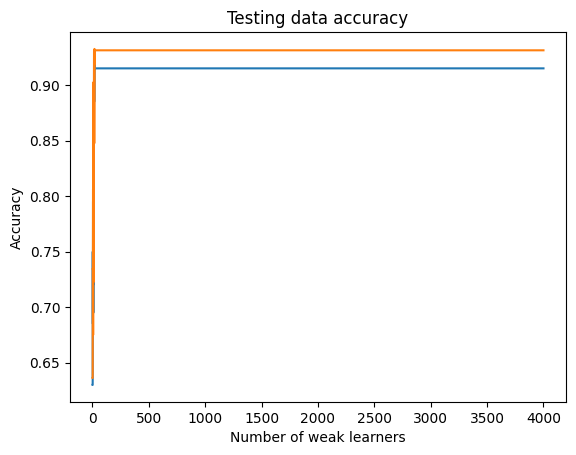

In [38]:
for _T in all_iteration:
  test_train_plot(_T)

بعد از یه تعدادی که دسته بند ضعیف دیگه همگرا شده و نیازی به اضافه کردن دسته بند ضعیف نیست (از مرحله حدودا 25 به بعد این اتفاق می افتد)